<a href="https://colab.research.google.com/github/andytorrestb/AIG/blob/master/naive_bayes_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Naive Bayes Example**

Predciting whether or not a person makes under $50K / year.  
0. Notebook Set Up
1. Data Preprocessing
2. Exploratory Data Analysis
3. Performance Metrics: Basic Model
4. Performance Metrics: Range of Split Percentages
5. Performance Metrics: Tuned Hyperparameters

## **0. Notebook Set Up**

Import files from google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Import required Python modules.

In [2]:
%%time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import roc_auc_score as roc_score

from sklearn.preprocessing import OrdinalEncoder

CPU times: user 342 ms, sys: 135 ms, total: 478 ms
Wall time: 365 ms


Functions for Data Pre-Processing

In [3]:
%%time

# Replace labels for columns. Ugly but gets the job done.
def replace_labels(df):
  df.columns = ['age', 'workclass', 'final_weight', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
             'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', '<=50K']
  return df

# Split features according to data type. Necessary?
def split_column_types(df):
  num_labels = []
  cat_labels = []

  for feature in df.columns:
    if df[feature].dtype == 'int64':
      num_labels.append(feature)
    else :
      cat_labels.append(feature)

  return num_labels, cat_labels

# returns a list containing names of columns cotaining 
# categorical data. 
def make_cat_labels(df):
  cat_labels = []
  for feature in df.columns:
    if df[feature].dtype != 'int64':
      cat_labels.append(feature)

  return cat_labels

# Remove leading and trailing spaces from the df
def strip_df(df, cat_labels):
  for feature in cat_labels:
    df[feature] = df[feature].str.strip()
  return df

# Helper function for remove_null_records
def check_for_null(df, cat_labels):
  missing_list = []

  for feature in cat_labels:
    count_list = df[feature].value_counts().index.tolist()
    if count_list.count('?'):
      missing_list.append(feature)
  
  return missing_list

# Helper function for remove_null_records
def insert_null_values(df, cat_labels):
  missing_list = check_for_null(df, cat_labels)
  for feature in missing_list:
    df[feature].replace('?', np.NaN, inplace = True)
  return df

# Helper function for process_cat_data
def remove_null_records(df, cat_labels):
  return insert_null_values(df, cat_labels).dropna()

# Cleans categorical data by stripping spaces
# removing null records. 
def process_cat_data(df):
  cat_labels = make_cat_labels(df)

  df = strip_df(df, cat_labels)
  df = remove_null_records(df, cat_labels)

  return df

# Changes data type of target vector from string to integer
def convert_target_vector(df):
  df['<=50K'].replace('<=50K', 1, inplace = True)
  df['<=50K'].replace('>50K', 0, inplace = True)

  return df  

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.78 µs


Functions for producing distributions of a model's performance metrics.

In [4]:
%%time

# Here to remind me of my computer's hard work <3
def progress_bar(trial, no_trials):
    if trial != no_trials - 1:
      if trial % (no_trials / 20) == 0:
        print('#', end = '')
    else :
      print('#')

# Helper function for type_error()
def make_test_dict():
  df = pd.DataFrame()
  gnb = GaussianNB()
  t_pct = 0.5
  no_trials = 100

  return {'df': df, 'gnb': gnb, 't_pct': t_pct, 'no_trials': no_trials}

# Simple sanity check. 
def type_error(model):
  test = make_test_dict()

  if type(model) != type(test):
    return 1

  if len(model) == 0:
    return 1
  
  for feature in test.keys():
    if type(test[feature]) != type(model[feature]):
      return 1

# Returns dictionary that contains resulting metrics distributions 
def model_dist(model):

  if type_error(model):
    print('type error: check definition of "model"')
    return

  # lists to store distributions of different metrics.
  f1_dist = []
  acc_dist = []
  roc_dist = []

  # Do that one thing. TODO: look this up
  model['df'] = model['df'].sample(frac = 1).reset_index(drop = True)

  # Instantiate the tranformer
  ec = OrdinalEncoder()
  
  for x in range(model['no_trials']):
    X = model["df"].drop(columns = '<=50K')
    y = model["df"]["<=50K"]

    X = ec.fit_transform(X)

    # Split into training/testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = model['t_pct'], stratify = y)
  
    # fit the model
    model['gnb'].fit(X_train, y_train)

    # Make prediction
    y_pred = model['gnb'].predict(X_test)

    # Update individual metrics
    f1_dist.append(f1_score(y_test, y_pred))
    acc_dist.append(acc_score(y_test, y_pred))
    roc_dist.append(roc_score(y_test, y_pred))

    # Print small progress bar.
    progress_bar(x, model['no_trials'])
  
  return {'f1': f1_dist, 'acc': acc_dist, 'roc': roc_dist, 't_pct': model['t_pct']}

def make_model_dict(train, t_pct, no_trials):
  return {'df': train, 'gnb': GaussianNB(), 't_pct': t_pct, 'no_trials': no_trials}

# Returns a dictionary containing three df, that each have 
# one of the three metrics distributions for evaluating model performance. 
def split_dist(train, t_range, no_trials):
  split_dist = []

  for t_pct in range(t_range['l_bound'], t_range['u_bound'], t_range['incr']):
    model = make_model_dict(train, t_pct / 100, no_trials)
    split_dist.append(model_dist(model))

  return pd.DataFrame(split_dist)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


Functions for graphing distributions of model metrics.

In [5]:
%%time

def metrics_histplot(metrics):
  # Graph perfomance distributions for model metrics. 
  perf_fig, axes = plt.subplots(1, 3, figsize = (30, 10));
  perf_fig.suptitle('Perfomance Metrics ', y = 1.02);
  perf_fig.tight_layout()

  scores = list(metrics.keys())[:3]

  index = 0
  for score in scores:
    sns.histplot(ax = axes[index], x = metrics[score])
    axes[index].set_title(score)
    index += 1

def metrics_boxplot(metrics):
  # Graph perfomance distributions for model metrics. 
  perf_fig, axes = plt.subplots(1, 3, figsize = (30, 10));
  perf_fig.suptitle('Perfomance Metrics ', y = 1.02);
  perf_fig.tight_layout()
  index = 0

  scores = list(metrics.keys())[:3]
  
  for score in scores:
      sns.boxplot(ax = axes[index], y = metrics[score])
      axes[index].set_title(score)
      index += 1

# Graph performance metrics across a range of test/train
# split values. Please enter all values as integers.
# They all represent percentages.   
# TODO: 1. use dicts to simplify the parameters.
#       2. finish
# def graph_metrics_by_split(t_range):

#   for t_pct in range(t_range['l_bound'], t_range['u_bound'], t_range['incr']):

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


## **1. Data Preprocessing** 

In [6]:
%%time

# Load and clean training data. 
path = '/content/drive/My Drive/adult.csv'
train = replace_labels(pd.read_csv(path))

train = process_cat_data(train)
train = convert_target_vector(train)

CPU times: user 275 ms, sys: 25.3 ms, total: 301 ms
Wall time: 326 ms


## **2. Exploratory Data Analysis**

## **3. Performance Metrics: Basic Model**


In [7]:
%%time

# Run model and produce distributions for performance metrics.
model = {'df': train, 'gnb': GaussianNB(), 't_pct': 0.5, 'no_trials': 5}
metrics = model_dist(model)

#####
CPU times: user 1.01 s, sys: 7.98 ms, total: 1.02 s
Wall time: 1.03 s


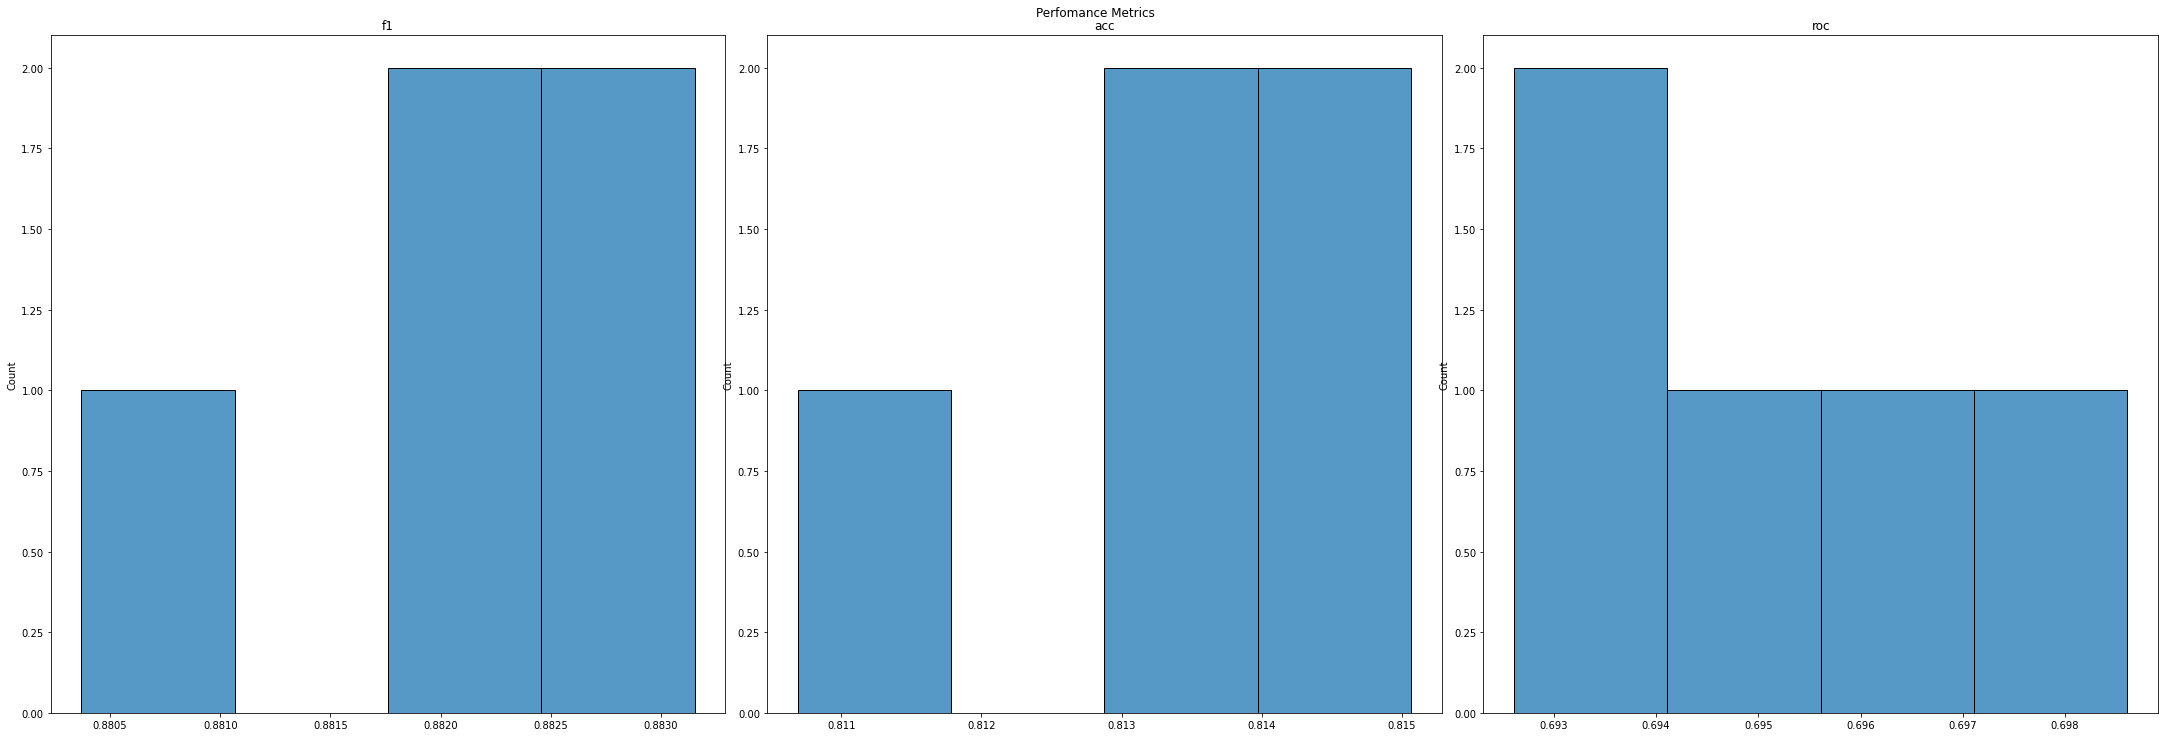

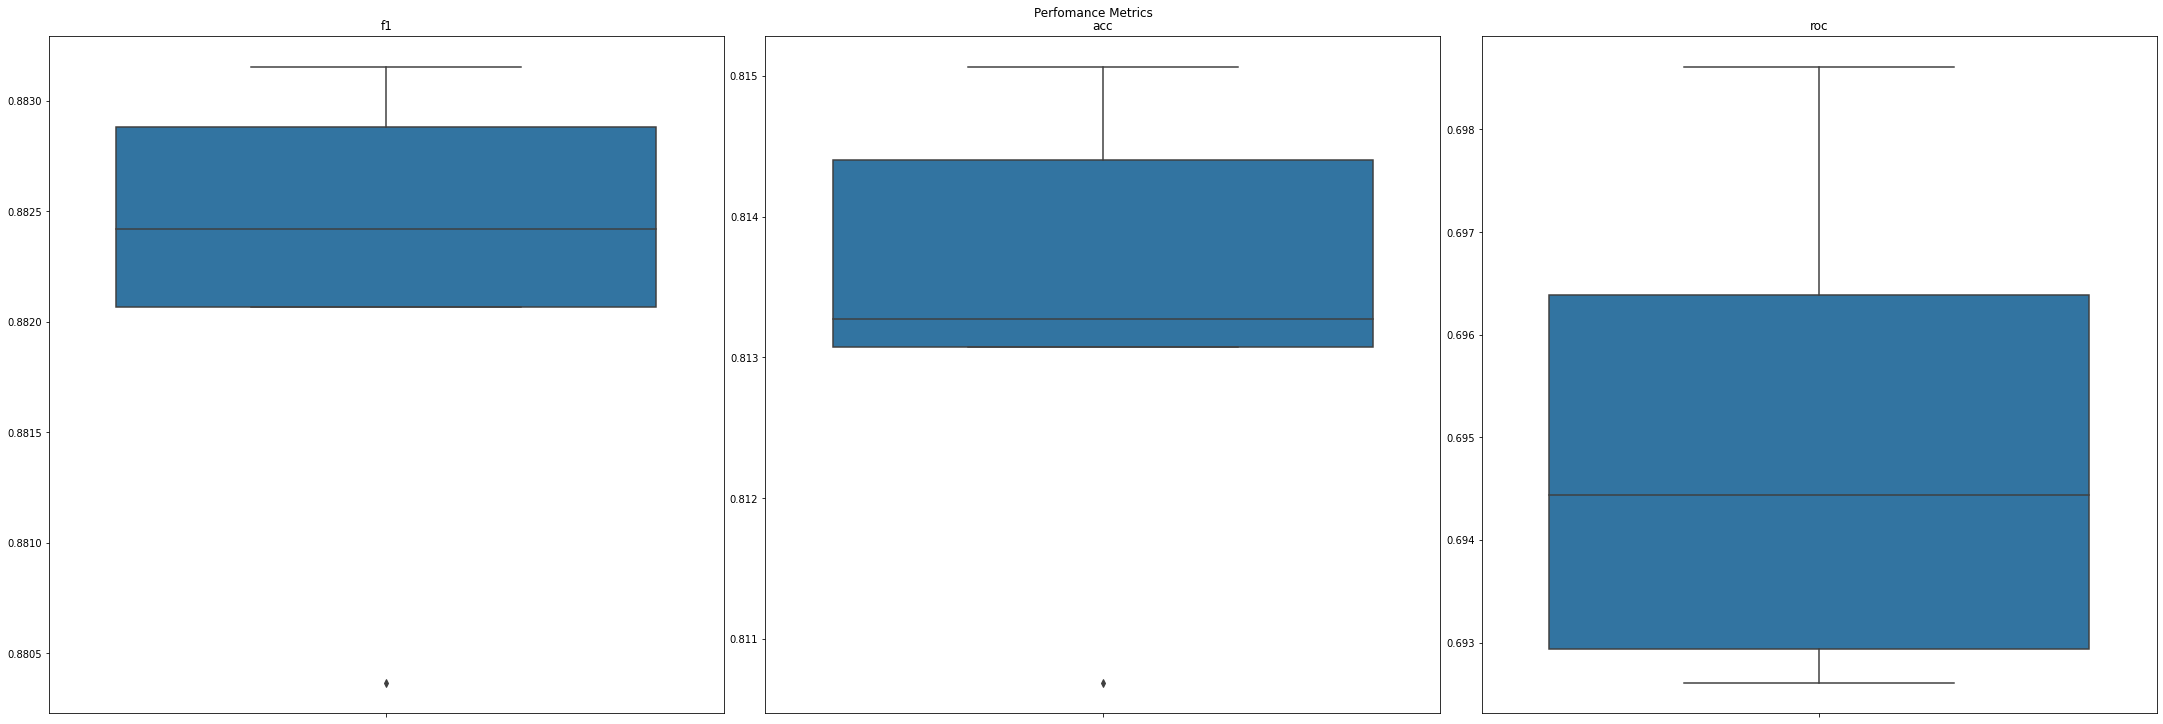

In [8]:
# Graph performance metrics for basic model.
metrics_histplot(metrics)
metrics_boxplot(metrics)

## **4. Performance Metrics: Range of Split Percentages**


In [9]:
%%time

# Range of split percentages to loop over. 
t_range = {'l_bound': 5, 'u_bound': 50, 'incr': 5}

# Produce dictionary containing dictionaries that store the 
# performance metrics for each t_pct value. 
dist_split = split_dist(train, t_range, 25)
#TODO: re-write split_dist to that each record holds the metrics single for a single run,
# not the entire minte carlo simulation ditribution. This should solve issues with graphing. 

######
######
######
######
######
######
######
######
######
CPU times: user 44 s, sys: 295 ms, total: 44.2 s
Wall time: 44.6 s


In [82]:
dist_split

,f1,acc,roc,t_pct
0,"[0.8878699458107545, 0.8821324448146606, 0.873...","[0.8217362491716369, 0.8124585818422797, 0.799...","[0.7027039398321159, 0.6894178043604815, 0.677...",0.05
1,"[0.880166147455867, 0.8790523690773068, 0.8835...","[0.8087504143188597, 0.8070931388796818, 0.816...","[0.6812790360131769, 0.679730644518694, 0.7041...",0.10
2,"[0.8797645739910314, 0.8764516580383377, 0.883...","[0.8103867403314917, 0.8048618784530387, 0.816...","[0.6962117162241324, 0.687189106397922, 0.7035...",0.15
3,"[0.8852390417407678, 0.8773031825795645, 0.880...","[0.8181667495441737, 0.8057351234874855, 0.811...","[0.7015818091143686, 0.6857391792184099, 0.698...",0.20
4,"[0.8846928499496475, 0.8805869455220104, 0.879...","[0.8177960482694603, 0.8122264951597932, 0.809...","[0.7039859460643111, 0.7017031644588522, 0.692...",0.25
5,"[0.8789631384572504, 0.881365416899832, 0.8804...","[0.8080450878550116, 0.8125759752458835, 0.811...","[0.6870589067431379, 0.6971963612965721, 0.696...",0.30
6,"[0.8808482597495956, 0.8769572259883617, 0.880...","[0.8115942028985508, 0.8057213223453633, 0.810...","[0.6949692217056513, 0.6886427402788792, 0.690...",0.35
7,"[0.8819575719386683, 0.882087831464207, 0.8820...","[0.8136759220886863, 0.8135101533360961, 0.813...","[0.6996272321807524, 0.6972903870939625, 0.695...",0.40
8,"[0.882276241035671, 0.8803943452380952, 0.8805...","[0.8137478818242099, 0.8105061519192515, 0.810...","[0.697249259599055, 0.6914309277785451, 0.6919...",0.45


0


TypeError: ignored

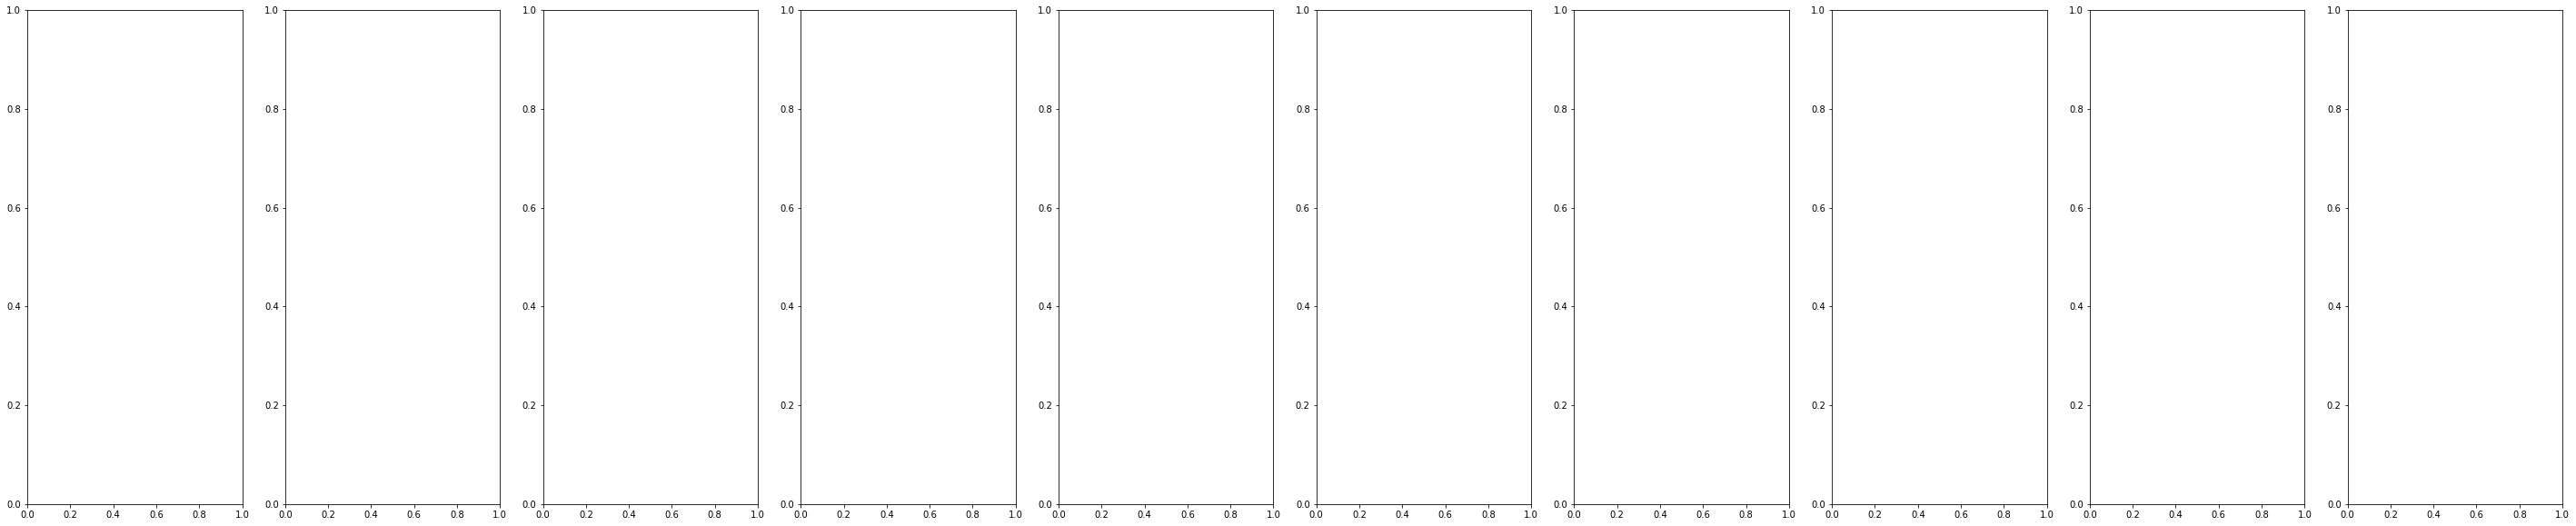

In [20]:
# for t_pct in dist_split.keys():
#   metrics_boxplot(dist_split[t_pct])
#   # TODO: Refactor to be nice and tidy like Dr. H's
#   # Should give clear visual comparisons of each t_pct value.
# print(type(dist_split.iat[0,0]))
# print(dist_split)

split_figs, axes = plt.subplots(1, 10, figsize = (50, 10))

for t_pct in range(int((t_range['u_bound']  - t_range['l_bound']) / t_range['incr'])):
  print(t_pct)
  sns.boxplot(y = 'f1', x = 't_pct', data = dist_split)
  # sns.boxplot(ax = axes[t_pct], y = dist_split.iat[0, t_pct])

# dist_split

In [78]:
print(type(dist_split))
sns.boxplot(x = 't_pct', y = 'f1', data = dist_split)

<class 'pandas.core.frame.DataFrame'>


TypeError: ignored